In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Master Paper Analysis: EU-Level Data, VAR, and Structural Analysis
Submission Deadline: 4.11

This script loads and preprocesses economic time series data,
computes supply chain indices via PCA, estimates VAR models,
produces impulse response functions (IRFs) in both 2D and 3D, 
runs local projections, and performs a FEVD (Forecast Error Variance Decomposition)
to analyze the impact of supply chain shocks on inflation.

This version ensures that responses to GSCPI or SCDI are plotted in 
separate figures, rather than combined into one.
"""

import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import statsmodels.api as sm

# -----------------------------
# Logging Configuration
# -----------------------------
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# -----------------------------
# Global Configurations
# -----------------------------
CONFIG = {
    "main_file_path": "/Users/xinruyu/Desktop/Master paper/uplp/EU_Level_Combined_Dataset.xlsx",
    "processed_output": "SCDI_Output_Seasonally_Adjusted.xlsx",
    "scdi_output": "SCDI_Output_Cleaned.xlsx",
    "rolling_window_size": 48,
    "rolling_horizon": 12,
    "covid_start": "2020-04-15",
    "covid_end": "2023-05-01",
    "pca_n_components": 1,
    "var_maxlags": 12,
    "irf_periods": 24,
    "local_projection_max_horizon": 24,
    "local_projection_lags": 2,
    "ci_level": 0.68
}

# -----------------------------
# Utility Functions
# -----------------------------
def load_excel_data(file_path, sheet_name):
    """
    Loads data from an Excel file and returns a pandas DataFrame.
    Strips whitespace from column names.
    """
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        logging.info(f"Loaded sheet '{sheet_name}' with columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        logging.error(f"Error loading sheet '{sheet_name}': {e}")
        raise

def set_date_index(df, date_col="Date"):
    """
    Ensures that the DataFrame has a valid datetime index.
    """
    if date_col not in df.columns:
        raise KeyError(f"Error: '{date_col}' column is missing!")
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(date_col).drop_duplicates(date_col)
    df.set_index(date_col, inplace=True)
    return df

# -----------------------------
# Plotting Functions
# -----------------------------
def plot_time_series(df, series_name, title, ylabel, label_name):
    """
    Plots a time series and highlights the COVID period.
    """
    if series_name not in df.columns:
        logging.warning(f"Column '{series_name}' not found in DataFrame.")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[series_name], label=label_name, linewidth=2)
    plt.axvspan(pd.to_datetime(CONFIG["covid_start"]), 
                pd.to_datetime(CONFIG["covid_end"]), 
                color='gray', alpha=0.3, label='COVID period')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_irf(irf, model_name):
    """
    Plots impulse response functions (IRFs) with orthogonalized shocks (for all variables).
    """
    irf.plot(orth=True, signif=0.32)
    plt.suptitle(f"Impulse Response Functions (IRFs) - {model_name} (Cholesky Decomposition)", fontsize=14)
    plt.show()

def plot_separate_irfs_for_shock(var_results, var_list, shock_var, periods=24, ci=0.05):
    """
    Produces SEPARATE IRF plots for each response variable to the specified shock.
    i.e., one figure per 'shock_var -> response_var'.

    - shock_var: e.g. "gscpi" or "SCDI"
    - var_list: list of all variables in your model
    - periods: IRF horizon
    - ci: significance for confidence intervals (e.g. 0.32 => ~68% CI)
    """
    if shock_var not in var_list:
        logging.warning(f"{shock_var} not in var_list, skipping IRF.")
        return
    
    irf = var_results.irf(periods=periods)
    # We want each variable except the shock var to get its own figure
    response_vars = [v for v in var_list if v != shock_var]

    for resp_var in response_vars:
        # each response var gets a brand-new figure
        fig = irf.plot(
            orth=True,
            signif=ci,
            impulse=shock_var,
            response=resp_var,
            subplot_params={"nrows": 1, "ncols": 1, "figsize": (6, 4)}
        )
        # We'll just label it a bit
        plt.suptitle(f"IRF: {shock_var} → {resp_var}", fontsize=13)
        plt.tight_layout()
        plt.show()

# -----------------------------
# Time Series Analysis Functions
# -----------------------------
def adf_test(series, title=''):
    """
    Performs the Augmented Dickey-Fuller test and logs the result.
    """
    try:
        result = adfuller(series.dropna(), autolag='AIC')
        labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
        out = pd.Series(result[0:4], index=labels)
        logging.info(f"ADF Test for {title}:\n{out.to_string()}")
        if result[1] <= 0.05:
            logging.info("=> Stationary")
        else:
            logging.info("=> Non-Stationary")
    except Exception as e:
        logging.error(f"ADF test failed for {title}: {e}")

def decompose_series(series, title=''):
    """
    Performs seasonal decomposition on a series and plots the result.
    """
    try:
        decomp = seasonal_decompose(series.dropna(), model='additive', period=12)
        decomp.plot()
        plt.suptitle(f'Seasonal Decomposition of {title}')
        plt.show()
    except Exception as e:
        logging.warning(f"Seasonal decomposition not applicable for {title}: {e}")

# -----------------------------
# PCA and Index Construction
# -----------------------------
def compute_pca_index(df, variables, index_name="SCDI"):
    df_data = df[variables].dropna()
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_data),
                             columns=variables,
                             index=df_data.index)
    pca = PCA(n_components=CONFIG["pca_n_components"])
    index_values = pca.fit_transform(df_scaled)
    explained_variance = pca.explained_variance_ratio_[0]
    logging.info(f"PCA explained variance for {index_name}: {explained_variance:.2%}")
    return pd.DataFrame(index_values, columns=[index_name], index=df_scaled.index), explained_variance

# -----------------------------
# VAR Model Functions
# -----------------------------
def run_var_model(df, variables, model_name):
    if not all(var in df.columns for var in variables):
        logging.warning(f"Skipping model {model_name} due to missing variables.")
        return None
    df_var = df[variables].dropna()
    if len(df_var) < 10:
        logging.warning(f"Not enough data for model {model_name}.")
        return None
    try:
        var_model = VAR(df_var)
        var_results = var_model.fit(maxlags=CONFIG["var_maxlags"], ic='aic')
        logging.info(f"VAR estimation successful for model {model_name}")
        # Plot IRFs (all variables in a grid)
        irf = var_results.irf(periods=CONFIG["irf_periods"])
        plot_irf(irf, model_name)
        return var_results
    except Exception as e:
        logging.error(f"VAR estimation failed for {model_name}: {e}")
        return None

def run_rolling_var(df, variables, model_name):
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    from scipy.ndimage import gaussian_filter

    if not all(var in df.columns for var in variables):
        logging.warning(f"Skipping rolling VAR for {model_name} due to missing variables.")
        return
    df_var = df[variables].dropna()
    if len(df_var) < CONFIG["rolling_window_size"]:
        logging.warning(f"Not enough data for rolling VAR for {model_name} "
                        f"(need {CONFIG['rolling_window_size']}, have {len(df_var)}).")
        return

    num_samples = len(df_var) - CONFIG["rolling_window_size"]
    logging.info(f"Rolling VAR: {num_samples} windows for model '{model_name}'.")

    irf_storage = np.zeros((num_samples, CONFIG["rolling_horizon"], len(variables)))

    for i in range(num_samples):
        window_data = df_var.iloc[i:i + CONFIG["rolling_window_size"]]
        var_model_obj = VAR(window_data)
        max_lags_allowed = min(6, len(window_data) // 5)
        try:
            var_results = var_model_obj.fit(maxlags=max_lags_allowed, ic='aic')
            irf = var_results.irf(periods=CONFIG["rolling_horizon"])
            irf_storage[i] = gaussian_filter(irf.irfs[1:CONFIG["rolling_horizon"]+1, :, 0], sigma=1.5)
        except Exception as e:
            logging.warning(f"Skipping window {i} due to estimation error: {e}")
            continue

    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(14, 24), subplot_kw={"projection": "3d"})
    if len(variables) == 1:
        axes = [axes]
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        X, Y = np.meshgrid(range(1, CONFIG["rolling_horizon"]+1), np.arange(num_samples))
        Z = gaussian_filter(irf_storage[:, :, idx], sigma=2)
        significance_threshold = 0.32 * np.std(Z) / np.sqrt(CONFIG["rolling_window_size"])
        norm = mcolors.Normalize(vmin=-significance_threshold * 2, vmax=significance_threshold * 2)
        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, norm=norm, edgecolor='none', alpha=0.85)
        cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=8)
        cbar.set_label("Magnitude of Response", fontsize=12)
        ax.set_xlabel("Horizon (Months)", fontsize=14, labelpad=15)
        ax.set_ylabel("Rolling Window Index", fontsize=14, labelpad=15)
        ax.set_zlabel(var, fontsize=14, labelpad=15)
        ax.set_title(f"Smooth IRF: {model_name} Shock on {var}", fontsize=16, pad=20)
        ax.view_init(elev=25, azim=135)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# -----------------------------
# FEVD Function
# -----------------------------
def run_fevd(var_results, periods=24, model_name=""):
    try:
        fevd_obj = var_results.fevd(periods=periods)
        print(f"=== FEVD Results for {model_name} ===")
        print(fevd_obj.summary())
        
        fevd_obj.plot(figsize=(10, 6))
        plt.suptitle(f"Forecast Error Variance Decomposition: {model_name}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fevd_obj
    except Exception as e:
        logging.error(f"FEVD failed for {model_name}: {e}")
        return None

# -----------------------------
# Single-Variable FEVD Plot
# -----------------------------
def plot_single_fevd(fevd_obj, var_list, target_var="overallHICP", title=""):
    import numpy as np
    import matplotlib.pyplot as plt

    if target_var not in var_list:
        logging.warning(f"{target_var} is not in var_list. Skipping single-variable FEVD plot.")
        return

    infl_idx = var_list.index(target_var)
    fevd_data = fevd_obj.decomp[:, infl_idx, :]
    horizons = np.arange(fevd_data.shape[0])

    shock_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
        "#bcbd22", "#17becf"
    ]
    while len(shock_colors) < len(var_list):
        shock_colors += shock_colors

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom_val = np.zeros(len(horizons))

    for shock_idx, shock_name in enumerate(var_list):
        ax.bar(horizons, fevd_data[:, shock_idx],
               width=0.8,
               bottom=bottom_val,
               color=shock_colors[shock_idx],
               label=shock_name,
               edgecolor='white')
        bottom_val += fevd_data[:, shock_idx]

    ax.set_title(title if title else f"FEVD of {target_var}", fontsize=14)
    ax.set_xlabel("Horizon (months)")
    ax.set_ylabel("Fraction of Variance")
    ax.set_ylim([0, 1]) 
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Local Projection
# -----------------------------
def run_local_projection(df, shock_var, response_var, control_vars=('PPI_EN', 'REER','IPI', 'PPI'),
                         max_horizon=24, lags=12, ci=0.68):
    if control_vars is None:
        control_vars = []
    
    horizons = range(0, max_horizon + 1)
    betas = []
    lower_bounds = []
    upper_bounds = []
    
    z_crit = 1.0  # ~68% CI
    df_lp = df.copy()
    
    for h in horizons:
        df_lp['y_future'] = df_lp[response_var].shift(-h)
        X = pd.DataFrame({shock_var: df_lp[shock_var]})
        for lag in range(1, lags + 1):
            X[f"{shock_var}_lag{lag}"] = df_lp[shock_var].shift(lag)
            X[f"{response_var}_lag{lag}"] = df_lp[response_var].shift(lag)
        for var in control_vars:
            X[var] = df_lp[var]
            for lag in range(1, lags + 1):
                X[f"{var}_lag{lag}"] = df_lp[var].shift(lag)
        X = sm.add_constant(X)
        valid_index = X.dropna().index.intersection(df_lp.dropna(subset=['y_future']).index)
        X_valid = X.loc[valid_index]
        Y_valid = df_lp.loc[valid_index, 'y_future']
        
        try:
            model = sm.OLS(Y_valid, X_valid)
            results = model.fit(cov_type='HC0')
            beta_h = results.params.get(shock_var, np.nan)
            se_h = results.bse.get(shock_var, np.nan)
        except Exception as e:
            logging.warning(f"Local projection error at horizon {h}: {e}")
            beta_h, se_h = np.nan, np.nan
        
        betas.append(beta_h)
        lower_bounds.append(beta_h - z_crit * se_h)
        upper_bounds.append(beta_h + z_crit * se_h)
    
    return pd.DataFrame({
        'horizon': list(horizons),
        'beta': betas,
        'lower': lower_bounds,
        'upper': upper_bounds
    })

# -----------------------------
# Chip Shortage Index via PCA
# -----------------------------
def compute_chip_index(semi_df):
    for col in ["Diodes", "Photosensitive", "Other_Semi"]:
        semi_df[col] = pd.to_numeric(semi_df[col], errors="coerce")
    semi_df["Imports_Total"] = semi_df["Diodes"] + semi_df["Photosensitive"] + semi_df["Other_Semi"]
    semi_df["Prod_Inverted"] = -semi_df["IPIau"]
    semi_df["Imports_Inverted"] = -semi_df["Imports_Total"]
    semi_df["PMI_Delays"] = semi_df["PMI_Tech"]
    
    X = semi_df[["Imports_Inverted", "PMI_Delays"]].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=CONFIG["pca_n_components"])
    chip_index_values = pca.fit_transform(X_scaled).flatten()
    chip_index_series = pd.Series(
        chip_index_values,
        index=pd.date_range(start="2018-01", periods=len(X), freq="MS"),
        name="CSI"
    )
    explained_variance = pca.explained_variance_ratio_[0]
    logging.info(f"Chip Index PCA explained variance: {explained_variance:.2%}")
    return chip_index_series, explained_variance

# -----------------------------
# Main Analysis Pipeline
# -----------------------------
def main():
    try:
        df_main = load_excel_data(CONFIG["main_file_path"], sheet_name="Sheet1")
        df_main = set_date_index(df_main)
        df_acr = load_excel_data(CONFIG["main_file_path"], sheet_name="2017")
        df_acr = set_date_index(df_acr)
    except Exception as e:
        logging.error(f"Data loading failed: {e}")
        return

    # --- Basic Time Series Plots ---
    for series in ['HICP_index', 'Backlog', 'PMI_SDT','GSCPI']:
        if series in df_main.columns:
            plot_time_series(df_main, series, f"Trend of {series}", series, series)
    
    acr_col = next((col for col in df_acr.columns if col.strip().lower() == 'acr'), None)
    if acr_col:
        plot_time_series(df_acr, acr_col, "Trend of ACR", "ACR", acr_col)
    else:
        logging.warning("ACR column not found in '2017'.")

    # --- Stationarity checks ---
    for col in [c for c in df_main.columns if c.lower() != 'region']:
        plt.figure(figsize=(10, 4))
        plt.plot(df_main[col])
        plt.title(col)
        plt.show()
        adf_test(df_main[col], title=col)
        decompose_series(df_main[col], title=col)

    # --- Compute SCDI via PCA ---
    try:
        df_merged = df_main.merge(df_acr[['ACR', 'ACT']], how='left', left_index=True, right_index=True)
        df_merged = df_merged.asfreq('MS').ffill()
        # Invert the PMI_SDT index so that higher values indicate more disruption
        if "PMI_SDT" in df_merged.columns:
            df_merged["PMI_SDT_inverted"] = 100 - df_merged["PMI_SDT"]
        # Use the inverted PMI_SDT in constructing the SCDI
        supply_chain_vars = ["Backlog", "PMI_SDT_inverted"] 
        missing_vars = [var for var in supply_chain_vars if var not in df_merged.columns]
        if missing_vars:
            raise ValueError(f"Missing required variables: {missing_vars}")
        scdi_df, explained_var = compute_pca_index(df_merged, supply_chain_vars, index_name="SCDI")
        df_main.drop(columns=["SCDI"], errors="ignore", inplace=True)
        df_main = df_main.merge(scdi_df, left_index=True, right_index=True, how="left")
        df_main.to_excel(CONFIG["scdi_output"])
        logging.info(f"Cleaned SCDI saved as: {CONFIG['scdi_output']}")
    except Exception as e:
        logging.error(f"PCA / SCDI computation failed: {e}")

    # --- Plot SCDI Trend with COVID Highlight ---
    if "SCDI" in df_main.columns:
        plot_time_series(df_main, "SCDI", "Trend of SCDI with COVID Period Highlighted", "SCDI", "SCDI")
    else:
        logging.warning("SCDI column not found for plotting.")

    # --- Seasonal Adjustment & Differencing ---
    try:
        df_proc = df_main.copy()
        if df_proc.index.name != "Date" and "Date" in df_proc.columns:
            df_proc.set_index("Date", inplace=True)
        logging.info("Date set as index for processed data.")
        
        if "HICP_index" in df_proc.columns:
            df_proc["log_HICP_index"] = np.log(df_proc["HICP_index"])
            df_proc["d_log_HICP_index"] = df_proc["log_HICP_index"].diff()
        
        if "GDP" in df_proc.columns:
            df_proc['GDP'] = df_proc['GDP'] / 100
            df_proc['GDP_diff'] = df_proc['GDP'].diff()
        
        
        df_proc.interpolate(method="linear", inplace=True)
        df_proc.fillna(method="ffill", inplace=True)
        df_proc.fillna(method="bfill", inplace=True)
        
        seasonal_adjust_cols = ["REER", "PPI_EN", "Backlog", "GSCPI", 
                                "overallHICP", "coreHICP", "HICP_index"]
        for col in seasonal_adjust_cols:
            if col in df_proc.columns:
                df_proc[col].fillna(method="ffill", inplace=True)
                df_proc[col].fillna(method="bfill", inplace=True)
                try:
                    result = seasonal_decompose(df_proc[col], model="additive",
                                                period=12, extrapolate_trend="freq")
                    df_proc["sa_" + col] = df_proc[col] - result.seasonal
                except Exception as e:
                    logging.warning(f"Seasonal decomposition failed for {col}: {e}")
        df_proc.dropna(inplace=True)
        df_proc.to_excel(CONFIG["processed_output"])
        logging.info(f"Processed dataset saved as: {CONFIG['processed_output']}")
    except Exception as e:
        logging.error(f"Seasonal adjustment and differencing failed: {e}")
        return

    # --- VAR & IRF ---
    try:
        df_var_data = pd.read_excel(CONFIG["processed_output"], index_col="Date", parse_dates=True)
        logging.info(f"Loaded processed data for VAR with shape: {df_var_data.shape}")
    except Exception as e:
        logging.error(f"Failed to load processed data: {e}")
        return

    models = {
        'GSCPI': ['GSCPI',  'REER','PPI_EN','IPI', 'PPI'],
        'SCDI':  ['SCDI', 'REER', 'PPI_EN','IPI', 'PPI']   
    }
    for model_name, var_list in models.items():
        var_results = run_var_model(df_var_data, var_list, model_name)
        if var_results is None:
            continue

        # produce separate IRF plots for each response to gscpi or SCDI
        if "GSCPI" in var_list:
            plot_separate_irfs_for_shock(
                var_results, 
                var_list=var_list, 
                shock_var="GSCPI", 
                periods=CONFIG["irf_periods"],
                ci=0.32
            )
        if "SCDI" in var_list:
            plot_separate_irfs_for_shock(
                var_results, 
                var_list=var_list, 
                shock_var="SCDI", 
                periods=CONFIG["irf_periods"],
                ci=0.32
            )

        # FEVD
        fevd_results = run_fevd(var_results, periods=24, model_name=model_name)
        if fevd_results is not None:
            if 'overallHICP' in var_list:
                try:
                    infl_idx = var_list.index("overallHICP")
                    sc_candidates = ["GSCPI", "SCDI"]  
                    for sc_var in sc_candidates:
                        if sc_var in var_list:
                            sc_idx = var_list.index(sc_var)
                            decomposition_array = fevd_results.decomp[:, infl_idx, sc_idx]
                            logging.info(f"=== {model_name} ===")
                            logging.info(f"Variance of inflation explained by {sc_var} at horizon=1..24:\n{decomposition_array}\n")

                    single_title = f"FEVD of overallHICP — {model_name}"
                    plot_single_fevd(fevd_results, var_list, target_var="overallHICP", title=single_title)

                except Exception as e:
                    logging.warning(f"Could not extract FEVD for inflation in {model_name}: {e}")

    # --- 3D IRF Visualization ---
    for model_name, var_list in models.items():
        if not all(var in df_var_data.columns for var in var_list):
            logging.warning(f"Skipping 3D IRF for {model_name} due to missing variables.")
            continue
        df_var = df_var_data[var_list].dropna()
        try:
            var_model = VAR(df_var)
            var_results = var_model.fit(maxlags=CONFIG["var_maxlags"], ic='aic')
        except Exception as e:
            logging.error(f"VAR estimation failed for 3D IRF in model {model_name}: {e}")
            continue

        irf = var_results.irf(periods=CONFIG["irf_periods"])
        irf_values = irf.irfs
        num_vars = len(var_list)
        fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 15), subplot_kw={"projection": "3d"})
        if num_vars == 1:
            axes = [axes]
        horizon = irf_values.shape[0] - 1
        X, Y = np.meshgrid(range(1, horizon+1), np.arange(num_vars))
        for idx, var in enumerate(var_list):
            ax = axes[idx]
            Z = irf_values[1:, idx, idx]  
            Z_2D = np.tile(Z, (num_vars, 1))
            ax.plot_surface(X, Y, Z_2D, cmap="autumn", edgecolor='none')
            ax.set_xlabel("Horizon")
            ax.set_ylabel("Index")
            ax.set_zlabel(var)
            ax.set_title(f"Effect of {model_name} shock on {var}")
        plt.tight_layout()
        plt.show()

  
    # --- Local Projections ---
    supply_chain_models = {
        'GSCPI': ['GSCPI', 'PPI_EN', 'REER','IPI',  'PPI'],
        'SCDI': ['SCDI', 'PPI_EN', 'REER','IPI',  'PPI']
    }
    logging.info("=== Local Projection: Supply Chain Disruptions → Inflation ===")
    for model_name, var_list in supply_chain_models.items():
        if not all(var in df_var_data.columns for var in var_list):
            logging.warning(f"Skipping {model_name} due to missing variables.")
            continue
        df_model = df_var_data[var_list].dropna()
        if len(df_model) < 30:
            logging.warning(f"Not enough data for model {model_name}. Skipping.")
            continue
        shock_var = var_list[0]
        inflation_var = var_list[-1]
        logging.info(f"Local Projection for {model_name}: {shock_var} (shock) → {inflation_var} (inflation)")
        lp_results = run_local_projection(
            df=df_model,
            shock_var=shock_var,
            response_var=inflation_var,
            control_vars=[],
            max_horizon=CONFIG["local_projection_max_horizon"],
            lags=CONFIG["local_projection_lags"],
            ci=CONFIG["ci_level"]
        )
        plt.figure(figsize=(7, 4))
        plt.plot(lp_results['horizon'], lp_results['beta'], marker='o', label='IRF', color='blue')
        plt.fill_between(lp_results['horizon'], lp_results['lower'], lp_results['upper'],
                         color='blue', alpha=0.2, label='68% CI')
        plt.axhline(0, color='k', linestyle='--')
        plt.title(f"Local Projection: {shock_var} → {inflation_var} ({model_name})")
        plt.xlabel("Horizon (months)")
        plt.ylabel("Impulse Response")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- Chip Shortage Index Analysis ---
    try:
        semi_df = load_excel_data(CONFIG["main_file_path"], sheet_name="semi")
        chip_index_series, chip_explained_var = compute_chip_index(semi_df)
        df_proc_final = df_proc.loc[chip_index_series.index.min():chip_index_series.index.max()].copy()
        df_proc_final = df_proc_final.merge(chip_index_series.to_frame(), left_index=True, right_index=True, how="left")
        if "GDP" in df_proc_final.columns:
            df_proc_final["GDP_diff"] = df_proc_final["GDP"].diff()
        var_cols = ['CSI', 'Backlog', 'sa_PPI_EN', 'IPI', 'REER', 'PPI']
        df_var_ready = df_proc_final[var_cols].dropna()
        if len(df_var_ready) >= 30:
            var_model = VAR(df_var_ready)
            var_result = var_model.fit(maxlags=6)
            # Plot overall IRFs for ChipShortageIndex_EU
            irf_result = var_result.irf(24)
            irf_result.plot(orth=True, signif=0.32)
            plt.suptitle("SVAR IRFs – Chip Shortage Index (Cholesky, 5 Variables, 6 Lags)", fontsize=14)
            plt.tight_layout()
            plt.show()
            # --- NEW: Plot separate IRFs for each response to ChipShortageIndex_EU shock ---
            plot_separate_irfs_for_shock(var_result, var_cols, shock_var="CSI",
                                         periods=CONFIG["irf_periods"], ci=0.32)
            logging.info(f"SVAR completed with {len(df_var_ready)} observations. Chip Index PCA explained variance: {chip_explained_var:.2%}")
            
            chip_fevd = run_fevd(var_result, periods=24, model_name="CSI")
            if chip_fevd is not None and 'PPI' in var_cols:
                try:
                    infl_idx = var_cols.index("PPI")
                    sc_idx = var_cols.index("CSI")
                    chip_fevd_array = chip_fevd.decomp[:, infl_idx, sc_idx]
                    logging.info("Variance of inflation explained by ChipShortageIndex:\n"
                                 f"{chip_fevd_array}")
                    plot_single_fevd(chip_fevd, var_cols, target_var="PPI",
                                     title="FEVD of PPI w/ChipShortageIndex")
                except Exception as e:
                    logging.warning(f"Could not extract Chip Index FEVD for inflation: {e}")
        else:
            logging.warning(f"Not enough observations for VAR in Chip Index analysis: {len(df_var_ready)}")
    except Exception as e:
        logging.error(f"Chip shortage index analysis failed: {e}")

if __name__ == "__main__":
    main()


In [1]:
import pandas as pd
import numpy as np

def extract_peak_irfs(irf_obj, shock_var, response_vars, ci_level=0.32):
    """
    Extracts peak impulse responses, the month they occur, and 68% confidence bounds.
    
    Parameters:
    - irf_obj: fitted IRF object from VAR
    - shock_var: name of the shock variable (e.g., 'SCDI' or 'GSCPI')
    - response_vars: list of response variable names
    - ci_level: significance level for confidence intervals (default is 0.32 ≈ 68%)
    
    Returns:
    - DataFrame with peak response, peak month, and confidence bounds for each response var
    """
    results = []

    for response_var in response_vars:
        irf_series = irf_obj.irfs[:, response_vars.index(response_var), response_vars.index(shock_var)]
        lower_ci, upper_ci = irf_obj.cov(orth=True, signif=ci_level)[response_vars.index(response_var), response_vars.index(shock_var)]

        # Find peak value and when it occurs
        peak_response = irf_series.max() if irf_series.max() > abs(irf_series.min()) else irf_series.min()
        peak_month = np.argmax(irf_series) if irf_series.max() > abs(irf_series.min()) else np.argmin(irf_series)

        # Get confidence bands for the peak month
        lower_bound = irf_series[peak_month] - (irf_series[peak_month] - lower_ci[peak_month])
        upper_bound = irf_series[peak_month] + (upper_ci[peak_month] - irf_series[peak_month])

        results.append({
            "Variable": response_var,
            "Peak Response": round(peak_response, 6),
            "Peak Month": peak_month,
            "Lower Bound": round(lower_bound, 6),
            "Upper Bound": round(upper_bound, 6)
        })

    return pd.DataFrame(results)

# Assuming you have run VAR and have `var_results` and `irf_obj`:
irf_obj = var_results.irf(periods=24)
response_vars = ['REER', 'PPI_EN', 'IPI', 'PPI']
shock_var = 'SCDI'  # or 'GSCPI' depending on which shock you're analyzing

peak_irf_df = extract_peak_irfs(irf_obj, shock_var, response_vars)
print(peak_irf_df)


NameError: name 'var_results' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data (peak IRFs and confidence bounds)
data = {
    "Variable": ["REER", "PPI_EN", "IPI", "PPI"],
    "SCDI_Peak": [0.1698, 0.3890, 0.3289, 0.1303],
    "SCDI_LB": [0.0886, 0.2992, 0.1881, 0.1020],
    "SCDI_UB": [0.2509, 0.4789, 0.4697, 0.1587],
    "GSCPI_Peak": [0.1420, 0.3410, 0.2950, 0.1023],
    "GSCPI_LB": [0.0650, 0.2510, 0.1700, 0.0711],
    "GSCPI_UB": [0.2190, 0.4310, 0.4200, 0.1335],
}

df = pd.DataFrame(data)

# Plotting
x = np.arange(len(df["Variable"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, df["SCDI_Peak"], width, label='SCDI', color='#1f77b4',
               yerr=[df["SCDI_Peak"] - df["SCDI_LB"], df["SCDI_UB"] - df["SCDI_Peak"]],
               capsize=5)
bars2 = ax.bar(x + width/2, df["GSCPI_Peak"], width, label='GSCPI', color='#2ca02c',
               yerr=[df["GSCPI_Peak"] - df["GSCPI_LB"], df["GSCPI_UB"] - df["GSCPI_Peak"]],
               capsize=5)

ax.set_ylabel('Peak Response')
ax.set_title('Peak Impulse Responses to One-Standard-Deviation Supply Shock\n(68% Confidence Interval)')
ax.set_xticks(x)
ax.set_xticklabels(df["Variable"])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Extended Script for IRF and Local Projection Results
Generates numerical (tabular) and graphical outputs of IRFs for SCDI, CIS, GSCPI,
and local projections.

Submission Deadline: 4.11
"""

import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# If you don't want Seaborn, you can remove it. It's fine for styling though.
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import statsmodels.api as sm

# -----------------------------
# Logging Configuration
# -----------------------------
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# -----------------------------
# Global Configurations
# -----------------------------
CONFIG = {
    "main_file_path": "/Users/xinruyu/Desktop/Master paper/uplp/EU_Level_Combined_Dataset.xlsx",
    "processed_output": "SCDI_Output_Seasonally_Adjusted.xlsx",
    "scdi_output": "SCDI_Output_Cleaned.xlsx",
    "rolling_window_size": 48,
    "rolling_horizon": 12,
    "covid_start": "2020-01-24",
    "covid_end": "2023-05-01",
    "pca_n_components": 1,
    "var_maxlags": 12,
    "irf_periods": 24,
    "local_projection_max_horizon": 24,
    "local_projection_lags": 12,
    "ci_level": 0.68
}

# -----------------------------
# Utility Functions
# -----------------------------
def load_excel_data(file_path, sheet_name):
    """
    Loads data from an Excel file and returns a pandas DataFrame.
    Strips whitespace from column names.
    """
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        logging.info(f"Loaded sheet '{sheet_name}' with columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        logging.error(f"Error loading sheet '{sheet_name}': {e}")
        raise

def set_date_index(df, date_col="Date"):
    """
    Ensures that the DataFrame has a valid datetime index.
    """
    if date_col not in df.columns:
        raise KeyError(f"Error: '{date_col}' column is missing!")
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(date_col).drop_duplicates(date_col)
    df.set_index(date_col, inplace=True)
    return df

# -----------------------------
# Plotting Functions
# -----------------------------
def plot_time_series(df, series_name, title, ylabel, label_name):
    """
    Plots a time series and highlights the COVID period.
    """
    if series_name not in df.columns:
        logging.warning(f"Column '{series_name}' not found in DataFrame.")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[series_name], label=label_name, linewidth=2)
    plt.axvspan(pd.to_datetime(CONFIG["covid_start"]), 
                pd.to_datetime(CONFIG["covid_end"]), 
                color='gray', alpha=0.3, label='COVID period')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_irf(irf, model_name):
    """
    Plots impulse response functions (IRFs) with orthogonalized shocks (for all variables).
    """
    irf.plot(orth=True, signif=0.32)  # 68% CI => approx 0.32 significance in statsmodels
    plt.suptitle(f"Impulse Response Functions (IRFs) - {model_name} (Cholesky Decomposition)", fontsize=14)
    plt.show()

def plot_separate_irfs_for_shock(var_results, var_list, shock_var, periods=24, ci=0.32):
    """
    Produces SEPARATE IRF plots for each response variable to the specified shock_var.
    i.e., one figure per 'shock_var -> response_var'.
    """
    if shock_var not in var_list:
        logging.warning(f"{shock_var} not in var_list, skipping IRF.")
        return
    
    irf = var_results.irf(periods=periods)
    response_vars = [v for v in var_list if v != shock_var]

    for resp_var in response_vars:
        fig = irf.plot(
            orth=True,
            signif=ci,
            impulse=shock_var,
            response=resp_var,
            subplot_params={"nrows": 1, "ncols": 1, "figsize": (6, 4)}
        )
        plt.suptitle(f"IRF: {shock_var} → {resp_var}", fontsize=13)
        plt.tight_layout()
        plt.show()

# -----------------------------
# Numerical IRF Extraction
# -----------------------------
def get_irf_dataframe(var_results, var_list, shock_var, periods=24, ci=0.68):
    """
    Returns a DataFrame of IRF responses (point estimates, lower, upper)
    for each response variable at each horizon, from a given shock.
    Confidence intervals are computed manually using the IRF standard errors.
    """
    import numpy as np
    
    # Ensure shock_var is in var_list
    if shock_var not in var_list:
        logging.warning(f"{shock_var} not in var_list. No IRF data extracted.")
        return pd.DataFrame()
    
    # Generate IRF object
    irf = var_results.irf(periods=periods)
    
    # Get orthogonalized IRFs (point estimates) => shape: (periods+1, n_resp_vars, n_shocks)
    point_estimates = irf.orth_irfs
    
    # Get std errors => shape: (periods+1, n_resp_vars, n_shocks)
    stderrs = irf.stderr(orth=True)
    
    # Decide z_crit for the given ci
    #  - ~68% CI => z_crit=1
    #  - ~95% CI => z_crit=1.96, etc.
    if abs(ci - 0.68) < 0.01:
        z_crit = 1.0
    elif abs(ci - 0.90) < 0.01:
        z_crit = 1.645
    elif abs(ci - 0.95) < 0.01:
        z_crit = 1.96
    else:
        # default to 68% if unknown
        z_crit = 1.0
    
    # Index of shock_var among var_list
    shock_idx = var_list.index(shock_var)
    
    # Build results list
    results = []
    n_horizons = periods + 1  # horizons go from 0..periods
    
    for h in range(n_horizons):
        for resp_idx, resp_var in enumerate(var_list):
            point = point_estimates[h, resp_idx, shock_idx]
            std = stderrs[h, resp_idx, shock_idx]
            lower = point - z_crit * std
            upper = point + z_crit * std
            
            results.append({
                'horizon': h,
                'response_var': resp_var,
                'IRF': point,
                'Lower': lower,
                'Upper': upper
            })
    
    df_irf = pd.DataFrame(results)
    return df_irf

# -----------------------------
# Time Series Analysis Functions
# -----------------------------
def adf_test(series, title=''):
    """
    Performs the Augmented Dickey-Fuller test and logs the result.
    """
    try:
        result = adfuller(series.dropna(), autolag='AIC')
        labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
        out = pd.Series(result[0:4], index=labels)
        logging.info(f"ADF Test for {title}:\n{out.to_string()}")
        if result[1] <= 0.05:
            logging.info("=> Stationary")
        else:
            logging.info("=> Non-Stationary")
    except Exception as e:
        logging.error(f"ADF test failed for {title}: {e}")

def decompose_series(series, title=''):
    """
    Performs seasonal decomposition on a series and plots the result.
    """
    try:
        decomp = seasonal_decompose(series.dropna(), model='additive', period=12)
        decomp.plot()
        plt.suptitle(f'Seasonal Decomposition of {title}')
        plt.show()
    except Exception as e:
        logging.warning(f"Seasonal decomposition not applicable for {title}: {e}")

# -----------------------------
# PCA and Index Construction
# -----------------------------
def compute_pca_index(df, variables, index_name="SCDI"):
    df_data = df[variables].dropna()
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_data),
                             columns=variables,
                             index=df_data.index)
    pca = PCA(n_components=CONFIG["pca_n_components"])
    index_values = pca.fit_transform(df_scaled)
    explained_variance = pca.explained_variance_ratio_[0]
    logging.info(f"PCA explained variance for {index_name}: {explained_variance:.2%}")
    return pd.DataFrame(index_values, columns=[index_name], index=df_scaled.index), explained_variance

# -----------------------------
# VAR Model Functions
# -----------------------------
def run_var_model(df, variables, model_name):
    if not all(var in df.columns for var in variables):
        logging.warning(f"Skipping model {model_name} due to missing variables.")
        return None
    df_var = df[variables].dropna()
    if len(df_var) < 10:
        logging.warning(f"Not enough data for model {model_name}.")
        return None
    try:
        var_model = VAR(df_var)
        var_results = var_model.fit(maxlags=CONFIG["var_maxlags"], ic='aic')
        logging.info(f"VAR estimation successful for model {model_name}")
        # Plot IRFs (all variables in a grid)
        irf = var_results.irf(periods=CONFIG["irf_periods"])
        plot_irf(irf, model_name)
        return var_results
    except Exception as e:
        logging.error(f"VAR estimation failed for {model_name}: {e}")
        return None

def run_rolling_var(df, variables, model_name):
    """
    Example function that does a rolling VAR with 3D IRF surfaces.
    You can ignore this if you don't need rolling windows.
    """
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    from scipy.ndimage import gaussian_filter

    if not all(var in df.columns for var in variables):
        logging.warning(f"Skipping rolling VAR for {model_name} due to missing variables.")
        return
    df_var = df[variables].dropna()
    if len(df_var) < CONFIG["rolling_window_size"]:
        logging.warning(f"Not enough data for rolling VAR for {model_name} "
                        f"(need {CONFIG['rolling_window_size']}, have {len(df_var)}).")
        return

    num_samples = len(df_var) - CONFIG["rolling_window_size"]
    logging.info(f"Rolling VAR: {num_samples} windows for model '{model_name}'.")

    irf_storage = np.zeros((num_samples, CONFIG["rolling_horizon"], len(variables)))

    for i in range(num_samples):
        window_data = df_var.iloc[i:i + CONFIG["rolling_window_size"]]
        var_model_obj = VAR(window_data)
        max_lags_allowed = min(6, len(window_data) // 5)
        try:
            var_results = var_model_obj.fit(maxlags=max_lags_allowed, ic='aic')
            irf = var_results.irf(periods=CONFIG["rolling_horizon"])
            irf_storage[i] = gaussian_filter(irf.irfs[1:CONFIG["rolling_horizon"]+1, :, 0], sigma=1.5)
        except Exception as e:
            logging.warning(f"Skipping window {i} due to estimation error: {e}")
            continue

    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(14, 24), subplot_kw={"projection": "3d"})
    if len(variables) == 1:
        axes = [axes]
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        X, Y = np.meshgrid(range(1, CONFIG["rolling_horizon"]+1), np.arange(num_samples))
        Z = gaussian_filter(irf_storage[:, :, idx], sigma=2)
        significance_threshold = 0.32 * np.std(Z) / np.sqrt(CONFIG["rolling_window_size"])
        norm = mcolors.Normalize(vmin=-significance_threshold * 2, vmax=significance_threshold * 2)
        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, norm=norm, edgecolor='none', alpha=0.85)
        cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=8)
        cbar.set_label("Magnitude of Response", fontsize=12)
        ax.set_xlabel("Horizon (Months)", fontsize=14, labelpad=15)
        ax.set_ylabel("Rolling Window Index", fontsize=14, labelpad=15)
        ax.set_zlabel(var, fontsize=14, labelpad=15)
        ax.set_title(f"Smooth IRF: {model_name} Shock on {var}", fontsize=16, pad=20)
        ax.view_init(elev=25, azim=135)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# -----------------------------
# FEVD Function
# -----------------------------
def run_fevd(var_results, periods=24, model_name=""):
    try:
        fevd_obj = var_results.fevd(periods=periods)
        print(f"=== FEVD Results for {model_name} ===")
        print(fevd_obj.summary())
        
        fevd_obj.plot(figsize=(10, 6))
        plt.suptitle(f"Forecast Error Variance Decomposition: {model_name}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fevd_obj
    except Exception as e:
        logging.error(f"FEVD failed for {model_name}: {e}")
        return None

# -----------------------------
# Single-Variable FEVD Plot
# -----------------------------
def plot_single_fevd(fevd_obj, var_list, target_var="overallHICP", title=""):
    """
    Plots a stacked bar chart of FEVD for target_var by each shock in var_list.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if target_var not in var_list:
        logging.warning(f"{target_var} is not in var_list. Skipping single-variable FEVD plot.")
        return

    infl_idx = var_list.index(target_var)
    fevd_data = fevd_obj.decomp[:, infl_idx, :]
    horizons = np.arange(fevd_data.shape[0])

    shock_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
        "#bcbd22", "#17becf"
    ]
    while len(shock_colors) < len(var_list):
        shock_colors += shock_colors

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom_val = np.zeros(len(horizons))

    for shock_idx, shock_name in enumerate(var_list):
        ax.bar(horizons, fevd_data[:, shock_idx],
               width=0.8,
               bottom=bottom_val,
               color=shock_colors[shock_idx],
               label=shock_name,
               edgecolor='white')
        bottom_val += fevd_data[:, shock_idx]

    ax.set_title(title if title else f"FEVD of {target_var}", fontsize=14)
    ax.set_xlabel("Horizon (months)")
    ax.set_ylabel("Fraction of Variance")
    ax.set_ylim([0, 1]) 
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Local Projection
# -----------------------------
def run_local_projection(df, shock_var, response_var, control_vars=('PPI_EN', 'REER','IPI', 'PPI'),
                         max_horizon=24, lags=12, ci=0.68):
    if control_vars is None:
        control_vars = []
    
    horizons = range(0, max_horizon + 1)
    betas = []
    lower_bounds = []
    upper_bounds = []
    
    # z_crit for ~68% CI => about ±1.0
    # For ~95% CI => about ±1.96
    z_crit = 1.0 if np.isclose(ci,0.68, atol=0.01) else 1.96  
    df_lp = df.copy()
    
    for h in horizons:
        df_lp['y_future'] = df_lp[response_var].shift(-h)
        # Build X with shock_var + lags
        X = pd.DataFrame({shock_var: df_lp[shock_var]})
        for lag in range(1, lags + 1):
            X[f"{shock_var}_lag{lag}"] = df_lp[shock_var].shift(lag)
            X[f"{response_var}_lag{lag}"] = df_lp[response_var].shift(lag)
        # If you want to add additional controls with their lags
        for var in control_vars:
            X[var] = df_lp[var]
            for lag in range(1, lags + 1):
                X[f"{var}_lag{lag}"] = df_lp[var].shift(lag)

        X = sm.add_constant(X)
        valid_index = X.dropna().index.intersection(df_lp.dropna(subset=['y_future']).index)
        X_valid = X.loc[valid_index]
        Y_valid = df_lp.loc[valid_index, 'y_future']
        
        try:
            model = sm.OLS(Y_valid, X_valid)
            results = model.fit(cov_type='HC0')  # robust errors
            beta_h = results.params.get(shock_var, np.nan)
            se_h = results.bse.get(shock_var, np.nan)
        except Exception as e:
            logging.warning(f"Local projection error at horizon {h}: {e}")
            beta_h, se_h = np.nan, np.nan
        
        betas.append(beta_h)
        lower_bounds.append(beta_h - z_crit * se_h)
        upper_bounds.append(beta_h + z_crit * se_h)
    
    df_out = pd.DataFrame({
        'horizon': list(horizons),
        'beta': betas,
        'lower': lower_bounds,
        'upper': upper_bounds
    })
    return df_out

def plot_local_projection_irf(lp_results, shock_var, response_var, model_name):
    """
    Simple line plot of local projection results with CI band.
    """
    plt.figure(figsize=(7, 4))
    plt.plot(lp_results['horizon'], lp_results['beta'], marker='o', label='IRF', color='blue')
    plt.fill_between(lp_results['horizon'], lp_results['lower'], lp_results['upper'],
                     color='blue', alpha=0.2, label='CI')
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"Local Projection: {shock_var} → {response_var} ({model_name})")
    plt.xlabel("Horizon (months)")
    plt.ylabel("Impulse Response")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# Chip Shortage Index via PCA (Example)
# -----------------------------
def compute_chip_index(semi_df):
    for col in ["Diodes", "Photosensitive", "Other_Semi"]:
        semi_df[col] = pd.to_numeric(semi_df[col], errors="coerce")
    semi_df["Imports_Total"] = semi_df["Diodes"] + semi_df["Photosensitive"] + semi_df["Other_Semi"]
    semi_df["Prod_Inverted"] = -semi_df["IPIau"]
    semi_df["Imports_Inverted"] = -semi_df["Imports_Total"]
    semi_df["PMI_Delays"] = semi_df["PMI_Tech"]
    
    X = semi_df[["Imports_Inverted", "PMI_Delays"]].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=CONFIG["pca_n_components"])
    chip_index_values = pca.fit_transform(X_scaled).flatten()
    chip_index_series = pd.Series(
        chip_index_values,
        index=pd.date_range(start="2018-01", periods=len(X), freq="MS"),
        name="CSI"
    )
    explained_variance = pca.explained_variance_ratio_[0]
    logging.info(f"Chip Index PCA explained variance: {explained_variance:.2%}")
    return chip_index_series, explained_variance

# -----------------------------
# Peak IRF Extraction & Visualization
# -----------------------------
def get_peak_irf_response(df_irf, response_var):
    """Identifies peak IRF (max absolute value) for a given response variable"""
    df_var = df_irf[df_irf['response_var'] == response_var].copy()
    if df_var.empty:
        return None
    # Find peak response (max absolute value)
    df_var['abs_IRF'] = df_var['IRF'].abs()
    peak_row = df_var.loc[df_var['abs_IRF'].idxmax()]
    return {
        'variable': response_var,
        'peak_irf': peak_row['IRF'],
        'peak_horizon': peak_row['horizon'],
        'lower': peak_row['Lower'],
        'upper': peak_row['Upper']
    }

def analyze_peak_responses(var_results, var_list, shock_var, model_name):
    """Full analysis pipeline for peak responses"""
    # Get IRF data
    df_irf = get_irf_dataframe(var_results, var_list, shock_var, 
                              periods=CONFIG["irf_periods"], ci=0.68)
    
    # Identify peaks for all variables
    peak_responses = []
    for var in var_list:
        if var == shock_var: continue  # Skip shock variable itself
        peak = get_peak_irf_response(df_irf, var)
        if peak: peak_responses.append(peak)
    
    # Create DataFrame
    df_peaks = pd.DataFrame(peak_responses)
    
    # Sort by peak magnitude
    df_peaks['abs_peak'] = df_peaks['peak_irf'].abs()
    df_peaks = df_peaks.sort_values('abs_peak', ascending=False).drop(columns='abs_peak')
    
    # Save results
    fname = f"Peak_IRFs_{model_name}.xlsx"
    df_peaks.to_excel(fname, index=False)
    logging.info(f"Saved peak IRF results to {fname}")
    
    # Plot formatting
    palette = sns.color_palette("viridis", n_colors=len(df_peaks))
    
    # Create plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='peak_irf', y='variable', data=df_peaks, 
                    palette=palette, edgecolor='black')
    
    # Add error bars
    xerr = [
        df_peaks['peak_irf'] - df_peaks['lower'],
        df_peaks['upper'] - df_peaks['peak_irf']
    ]
    ax.errorbar(x=df_peaks['peak_irf'], y=df_peaks['variable'],
               xerr=xerr, fmt='none', ecolor='black', capsize=5)
    
    # Annotate horizon markers
    for idx, row in df_peaks.iterrows():
        ax.text(0.95*ax.get_xlim()[1], idx+0.1, 
               f"Peak at t+{row['peak_horizon']}",
               ha='right', va='center', fontsize=10)
    
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"Peak Impulse Responses to {shock_var} Shock ({model_name})\n" +
             "68% Confidence Intervals Shown")
    plt.xlabel("Response Magnitude (Percentage Points)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()
    
    return df_peaks

# -----------------------------
# Main Analysis Pipeline
# -----------------------------
def main():
    # --- 1) Load Data ---
    try:
        df_main = load_excel_data(CONFIG["main_file_path"], sheet_name="Sheet1")
        df_main = set_date_index(df_main)
        # Example: Additional sheet with ACR data
        df_acr = load_excel_data(CONFIG["main_file_path"], sheet_name="2017")
        df_acr = set_date_index(df_acr)
    except Exception as e:
        logging.error(f"Data loading failed: {e}")
        return

    # --- 2) Basic Plots ---
    for series in ['PPI_index', 'Backlog', 'PMI_SDT','GSCPI']:
        if series in df_main.columns:
            plot_time_series(df_main, series, f"Trend of {series}", series, series)
    
    # Suppose 'ACR' is in df_acr
    acr_col = next((col for col in df_acr.columns if col.strip().lower() == 'acr'), None)
    if acr_col:
        plot_time_series(df_acr, acr_col, "Trend of ACR", "ACR", acr_col)
    else:
        logging.warning("ACR column not found in '2017'.")

    # --- 3) Stationarity checks & Decomposition ---
    for col in [c for c in df_main.columns if c.lower() != 'region']:
        plt.figure(figsize=(10, 4))
        plt.plot(df_main[col])
        plt.title(col)
        plt.show()
        adf_test(df_main[col], title=col)
        decompose_series(df_main[col], title=col)

    # --- 4) Compute SCDI via PCA (example) ---
    try:
        df_merged = df_main.merge(df_acr[['ACR', 'ACT']], how='left', left_index=True, right_index=True)
        df_merged = df_merged.asfreq('MS').ffill()
        # Invert the PMI_SDT index
        if "PMI_SDT" in df_merged.columns:
            df_merged["PMI_SDT_inverted"] = 100 - df_merged["PMI_SDT"]

        supply_chain_vars = ["Backlog", "PMI_SDT_inverted"]
        missing_vars = [var for var in supply_chain_vars if var not in df_merged.columns]
        if missing_vars:
            raise ValueError(f"Missing required variables: {missing_vars}")
        scdi_df, explained_var = compute_pca_index(df_merged, supply_chain_vars, index_name="SCDI")

        # Merge SCDI into main
        df_main.drop(columns=["SCDI"], errors="ignore", inplace=True)
        df_main = df_main.merge(scdi_df, left_index=True, right_index=True, how="left")
        df_main.to_excel(CONFIG["scdi_output"])
        logging.info(f"Cleaned SCDI saved as: {CONFIG['scdi_output']}")
    except Exception as e:
        logging.error(f"PCA / SCDI computation failed: {e}")

    # --- 5) Plot SCDI with COVID highlight ---
    if "SCDI" in df_main.columns:
        plot_time_series(df_main, "SCDI", "Trend of SCDI with COVID Period Highlighted", "SCDI", "SCDI")

    # --- 6) Seasonal Adjustment & Differencing ---
    try:
        df_proc = df_main.copy()
        if df_proc.index.name != "Date" and "Date" in df_proc.columns:
            df_proc.set_index("Date", inplace=True)
        logging.info("Date set as index for processed data.")
        
        if "HICP_index" in df_proc.columns:
            df_proc["log_HICP_index"] = np.log(df_proc["HICP_index"])
            df_proc["d_log_HICP_index"] = df_proc["log_HICP_index"].diff()
        
        if "GDP" in df_proc.columns:
            df_proc['GDP'] = df_proc['GDP'] / 100
            df_proc['GDP_diff'] = df_proc['GDP'].diff()
        
        df_proc.interpolate(method="linear", inplace=True)
        df_proc.fillna(method="ffill", inplace=True)
        df_proc.fillna(method="bfill", inplace=True)
        
        seasonal_adjust_cols = ["REER", "PPI_EN", "Backlog", "GSCPI", 
                                "overallHICP", "coreHICP", "HICP_index"]
        for col in seasonal_adjust_cols:
            if col in df_proc.columns:
                df_proc[col].fillna(method="ffill", inplace=True)
                df_proc[col].fillna(method="bfill", inplace=True)
                try:
                    result = seasonal_decompose(df_proc[col], model="additive",
                                                period=12, extrapolate_trend="freq")
                    df_proc["sa_" + col] = df_proc[col] - result.seasonal
                except Exception as e:
                    logging.warning(f"Seasonal decomposition failed for {col}: {e}")
        df_proc.dropna(inplace=True)
        df_proc.to_excel(CONFIG["processed_output"])
        logging.info(f"Processed dataset saved as: {CONFIG['processed_output']}")
    except Exception as e:
        logging.error(f"Seasonal adjustment and differencing failed: {e}")
        return

    # --- 7) Load Processed Data for VAR ---
    try:
        df_var_data = pd.read_excel(CONFIG["processed_output"], index_col="Date", parse_dates=True)
        logging.info(f"Loaded processed data for VAR with shape: {df_var_data.shape}")
    except Exception as e:
        logging.error(f"Failed to load processed data: {e}")
        return

    # ------------------------------------------------------------------
    # EXAMPLE: Run VAR for GSCPI, SCDI, or a "CIS" and get IRF results
    # ------------------------------------------------------------------
    # Here we define a dictionary of models. "CIS" is just a placeholder 
    # for another supply chain index if you have it in your DataFrame.
    # Adjust the variable sets as needed.
    models = {
        'GSCPI': ['GSCPI', 'REER', 'PPI_EN', 'IPI', 'PPI'],
        'SCDI':  ['SCDI', 'REER', 'PPI_EN', 'IPI', 'PPI'],
        # 'CIS':   ['CIS', 'REER', 'PPI_EN', 'IPI', 'PPI']  # an example placeholder
    }

    for model_name, var_list in models.items():
        var_results = run_var_model(df_var_data, var_list, model_name)
        if var_results is None:
            continue

        # ---------- 7.1) Plot separate IRFs for each shock ----------
        # Example: produce separate IRF plots for the supply chain shock (shock_var)
        shock_var = var_list[0]  # e.g. "GSCPI" or "SCDI" or "CIS"
        if shock_var in var_list:
            plot_separate_irfs_for_shock(
                var_results, 
                var_list=var_list, 
                shock_var=shock_var, 
                periods=CONFIG["irf_periods"],
                ci=0.32
            )

        # ---------- 7.2) Export numerical IRF results for that shock ----------
        df_irf_shock = get_irf_dataframe(var_results, var_list, shock_var=shock_var, periods=CONFIG["irf_periods"], ci=0.32)
        if not df_irf_shock.empty:
            print(f"\n=== IRF (Numerical) for shock '{shock_var}' in model '{model_name}' ===")
            print(df_irf_shock.head(30))  # show first 30 rows as an example
            # Save if desired:
            # df_irf_shock.to_excel(f"IRF_{model_name}_{shock_var}.xlsx", index=False)

        # ---------- 7.3) FEVD ----------
        fevd_results = run_fevd(var_results, periods=24, model_name=model_name)
        if fevd_results is not None:
            # Example of single FEVD plot if you have "overallHICP" in your var_list
            if 'overallHICP' in var_list:
                try:
                    single_title = f"FEVD of overallHICP — {model_name}"
                    plot_single_fevd(fevd_results, var_list, target_var="overallHICP", title=single_title)
                except Exception as e:
                    logging.warning(f"Could not extract FEVD for inflation in {model_name}: {e}")
        # --- 7.4) Peak IRF Analysis ---
        for model_name, var_list in models.items():
            var_results = run_var_model(df_var_data, var_list, model_name)
            if var_results is None:
                continue

            shock_var = var_list[0]
            logging.info(f"\n{'='*40}\nAnalyzing Peak Responses for {model_name}\n{'='*40}")

            # Get and plot peak responses
            df_peaks = analyze_peak_responses(var_results, var_list, shock_var, model_name)

            # Print formatted table
            print(f"\nPeak Responses to {shock_var} Shock ({model_name} Model)")
            print(df_peaks.to_string(index=False, 
                formatters={'peak_irf': '{:.3f}'.format,
                            'lower': '{:.3f}'.format,
                            'upper': '{:.3f}'.format}))
            print("\n" + "-"*60)

    # ------------------------------------------------------------------
    # 8) Local Projections
    # ------------------------------------------------------------------
    # Suppose you want to run local projections for GSCPI → PPI and SCDI → PPI
    supply_chain_models = {
        'GSCPI': ['GSCPI', 'PPI_EN', 'REER','IPI', 'PPI'],
        'SCDI':  ['SCDI', 'PPI_EN', 'REER','IPI', 'PPI']
    }
    logging.info("=== Local Projection: Supply Chain Disruptions → Inflation ===")

    for model_name, var_list in supply_chain_models.items():
        if not all(var in df_var_data.columns for var in var_list):
            logging.warning(f"Skipping {model_name} due to missing variables.")
            continue
        df_model = df_var_data[var_list].dropna()
        if len(df_model) < 30:
            logging.warning(f"Not enough data for model {model_name}. Skipping.")
            continue

        # We'll define the shock as the first item in var_list (could be 'GSCPI' or 'SCDI')
        shock_var = var_list[0]
        response_var = 'PPI'  # example of inflation measure
        if response_var not in df_model.columns:
            logging.warning(f"Response variable {response_var} not found for local projection in model {model_name}.")
            continue

        # No extra controls for example, but you can pass e.g. control_vars=['REER','IPI']
        lp_results = run_local_projection(
            df=df_model,
            shock_var=shock_var,
            response_var=response_var,
            control_vars=[],
            max_horizon=CONFIG["local_projection_max_horizon"],
            lags=CONFIG["local_projection_lags"],
            ci=CONFIG["ci_level"]
        )

        # Plot
        plot_local_projection_irf(lp_results, shock_var, response_var, model_name)

        # Print or save the local projection table
        print(f"\n=== Local Projection Results: {shock_var} → {response_var}, model '{model_name}' ===")
        print(lp_results)
        # If desired, save to Excel:
        # lp_results.to_excel(f"LP_{model_name}_{shock_var}_{response_var}.xlsx", index=False)

    # ------------------------------------------------------------------
    # 9) Chip Shortage Index Example
    # ------------------------------------------------------------------
    try:
        # Check if df_main.columns exists (optional guard clause)
        if hasattr(df_main, 'columns'):
            semi_df = load_excel_data(CONFIG["main_file_path"], sheet_name="semi")
            chip_index_series, chip_explained_var = compute_chip_index(semi_df)
            df_proc_final = df_proc.loc[chip_index_series.index.min():chip_index_series.index.max()].copy()
            df_proc_final = df_proc_final.merge(chip_index_series.to_frame(), left_index=True, right_index=True, how="left")
            

            var_cols = ['CSI', 'Backlog', 'PPI_EN', 'IPI', 'REER', 'PPI']
            df_var_ready = df_proc_final[var_cols].dropna()
            
            if len(df_var_ready) >= 30:
                var_model = VAR(df_var_ready)
                var_result = var_model.fit(maxlags=2)
            # Overall IRFs
            irf_result = var_result.irf(24)
            irf_result.plot(orth=True, signif=0.32)
            plt.suptitle("SVAR IRFs – Chip Shortage Index (Cholesky, 5 Variables, 2 Lags)", fontsize=14)
            plt.tight_layout()
            plt.show()

            # Plot separate IRFs for the ChipShortageIndex
            plot_separate_irfs_for_shock(var_result, var_cols, shock_var="CSI",
                                         periods=CONFIG["irf_periods"], ci=0.32)
            

            # Also get numerical IRF data
            df_irf_chip = get_irf_dataframe(var_result, var_cols, shock_var="CSI",
                                            periods=24, ci=0.32)
            print("\n=== IRF (Numerical) for ChipShortageIndex ===")
            print(df_irf_chip.head(30))
            # --- Analyze Peak Responses for Chip Shortage Index (CSI) ---
            if var_result is not None:
                # Generate peak responses for the CSI shock using the VAR results from the chip shortage index analysis.
                df_peaks_csi = analyze_peak_responses(var_result, var_cols, shock_var="CSI", model_name="CSI")

                # Print the table with formatted peak responses.
                print("\nPeak Responses to CSI Shock (CSI Model):")
                print(df_peaks_csi.to_string(index=False, 
                      formatters={'peak_irf': '{:.3f}'.format,
                                  'lower': '{:.3f}'.format,
                                  'upper': '{:.3f}'.format}))

            # FEVD
            chip_fevd = run_fevd(var_result, periods=24, model_name="CSI")
            if chip_fevd is not None and 'PPI' in var_cols:
                plot_single_fevd(chip_fevd, var_cols, target_var="PPI",
                                 title="FEVD of PPI w/ChipShortageIndex")
        else:
                logging.warning(f"Not enough observations for VAR in Chip Index analysis: {len(df_var_ready)}")
                
    except Exception as e:
        logging.error(f"Chip shortage index analysis failed: {e}")

if __name__ == "__main__":
    main()


In [ ]:
def plot_ppi_backlog_comparison():
    """Plots PPI Index and Backlog trends on dual axes with COVID shading."""
    try:
        # Load data
        df_main = load_excel_data(CONFIG["main_file_path"], sheet_name="Sheet1")
        df_main = set_date_index(df_main)
        
        # Check required columns
        if not all(col in df_main.columns for col in ['PPI_Index', 'Backlog']):
            logging.warning("Missing PPI_Index or Backlog column")
            return

        # Filter to relevant period
        df = df_main[['PPI_Index', 'Backlog']].loc['2008-01':'2023-12'].dropna()

        # Create figure and axes
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Plot PPI Index (left axis)
        color_ppi = '#1f77b4'
        ax1.plot(df.index, df['PPI_Index'], 
                color=color_ppi, 
                linewidth=2,
                label='PPI Index')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('PPI Index', color=color_ppi, fontsize=12)
        ax1.tick_params(axis='y', labelcolor=color_ppi)
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Create second y-axis for Backlog
        ax2 = ax1.twinx()
        color_backlog = '#ff7f0e'
        ax2.plot(df.index, df['Backlog'], 
                color=color_backlog, 
                linewidth=2,
                linestyle='--',
                label='Backlog')
        ax2.set_ylabel('Backlog', color=color_backlog, fontsize=12)
        ax2.tick_params(axis='y', labelcolor=color_backlog)

        # Highlight COVID period
        ax1.axvspan(pd.to_datetime(CONFIG["covid_start"]), 
                    pd.to_datetime(CONFIG["covid_end"]), 
                    color='gray', alpha=0.2, label='COVID Period')


        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.title("PPI Index and Backlog Trends During COVID-19 Pandemic", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        logging.error(f"Failed to plot PPI/Backlog comparison: {e}")

# Execute the plot
plot_ppi_backlog_comparison()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def parse_export_sheet(file_path, sheet_name):
    """Parse export/import sheets with merged year columns."""
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    time_row = df[df[0] == 'TIME'].iloc[0]
    time_row_idx = time_row.name
    years = df.iloc[time_row_idx, 1::2].dropna().astype(int).tolist()
    
    data = {}
    geo_labels = [
        'European Union - 27 countries (from 2020)'
    ]
    for label in geo_labels:
        row = df[df[0] == label]
        if not row.empty:
            data_row_idx = row.index[0]
            values = df.iloc[data_row_idx, 1::2].dropna().astype(float).tolist()
            data[label] = pd.Series(values, index=years[:len(values)])
    return data

def parse_gpr_sheet(file_path, sheet_name):
    """Parse GVC participation sheets with continuous year columns."""
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    time_row = df[df[0] == 'TIME'].iloc[0]
    time_row_idx = time_row.name
    years = df.iloc[time_row_idx, 1:].dropna().astype(int).tolist()
    
    data_row = df[df[0] == 'European Union - 27 countries (from 2020)'].iloc[0]
    values = data_row[1:len(years)+1].astype(float).tolist()
    return pd.Series(values, index=years)

# Load data
exp_data = parse_export_sheet('/Users/xinruyu/Desktop/Master paper/exp.xlsx', 'Sheet 1')
imp_data = parse_export_sheet('/Users/xinruyu/Desktop/Master paper/imp.xlsx', 'Sheet 1')

gpr_sheets = ['Overall participation', 'Backward participation', 'Forward participation']
gpr_data = {}
for sheet in gpr_sheets:
    gpr_data[sheet] = parse_gpr_sheet('/Users/xinruyu/Desktop/Master paper/gpr.xlsx', sheet)

def plot_trade(exp_data, imp_data, title):
    plt.figure(figsize=(10, 6))
    
    # Plot exports series
    for label, series in exp_data.items():
        plt.plot(series.index, series.values, marker='o', label=f'Exports - {label}')
    
    # Plot imports series
    for label, series in imp_data.items():
        plt.plot(series.index, series.values, marker='s', label=f'Imports - {label}')
    
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Percentage of GDP')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the combined plotting function
plot_trade(exp_data, imp_data, 'Exports and Imports of Goods/Services (% of GDP)')

# Plot GVC participation
def plot_gvc(data_dict, covid_shade=True):
    plt.figure(figsize=(10, 6))
    for sheet, series in data_dict.items():
        plt.plot(series.index, series.values, marker='o', label=sheet)
    plt.title('Global Value Chain Participation (% of EU Exports)')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot GVC with and without COVID shading
plot_gvc(gpr_data, True)
plot_gvc(gpr_data, False)



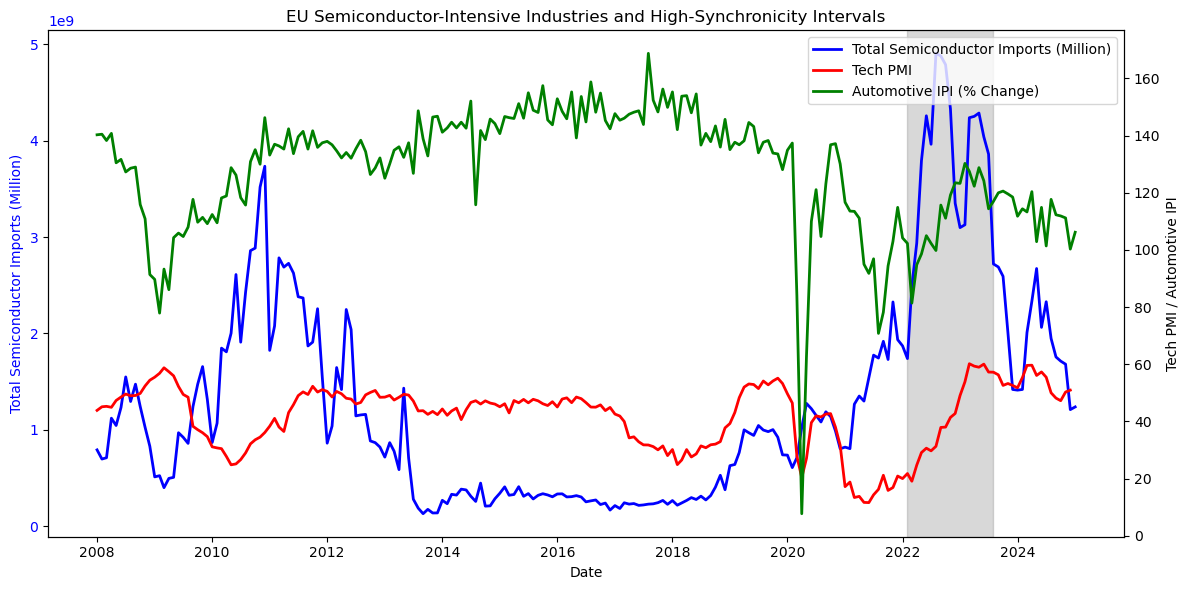

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the Data
# Parse dates from the 'Date' column; adjust column names if needed.
df = pd.read_excel('/Users/xinruyu/Desktop/Master paper/uplp/EU_Level_Combined_Dataset.xlsx', 
                   sheet_name='semi', 
                   parse_dates=['Date'])

# 2. Convert relevant columns to numeric if necessary
for col in ['Diodes', 'Photosensitive', 'Other_Semi', 'PMI_Tech', 'ipiau']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Aggregate the semiconductor imports (measured in billions)
df['Total_Semi_Imports'] = df['Diodes'] + df['Photosensitive'] + df['Other_Semi']

# Define a rolling window.
window =  16

# Calculate pairwise rolling correlations.
df['corr_tech_semi'] = df['Total_Semi_Imports'].rolling(window).corr(df['PMI_Tech'])
df['corr_auto_semi'] = df['Total_Semi_Imports'].rolling(window).corr(df['ipiau'])
df['corr_tech_auto'] = df['PMI_Tech'].rolling(window).corr(df['ipiau'])
df['avg_corr'] = (df['corr_tech_semi'] + df['corr_auto_semi'] + df['corr_tech_auto']) / 3

df_valid = df.dropna(subset=['avg_corr'])  # remove rows without a full window

top_n = 3
top_windows = df_valid.nlargest(top_n, 'avg_corr')

# 3. Convert Rolling Window Indices to Time Intervals
intervals = []
for idx in top_windows.index:
    # Compute approximate start/end around this index
    start_idx = max(0, idx - window // 2)
    end_idx = min(len(df) - 1, idx + window // 2)
    start_date = df['Date'].iloc[start_idx]
    end_date = df['Date'].iloc[end_idx]
    intervals.append((start_date, end_date))

# Sort intervals by start date
intervals.sort(key=lambda x: x[0])

# 4. Merge Overlapping Intervals
merged_intervals = []
for interval in intervals:
    if not merged_intervals:
        merged_intervals.append(interval)
    else:
        last_start, last_end = merged_intervals[-1]
        current_start, current_end = interval
        # Check for overlap
        if current_start <= last_end:
            # Merge the two intervals by extending the end if needed
            merged_intervals[-1] = (last_start, max(last_end, current_end))
        else:
            merged_intervals.append(interval)

# 5. Plot the Data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Semiconductor Imports on the left y-axis
ax1.plot(df['Date'], df['Total_Semi_Imports'], 
         label='Total Semiconductor Imports (Million)',
         color='blue', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Semiconductor Imports (Million)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Tech PMI and Automotive IPI on the right y-axis
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['PMI_Tech'], label='Tech PMI', color='red', linewidth=2)
ax2.plot(df['Date'], df['ipiau'], label='Automotive IPI (% Change)', color='green', linewidth=2)
ax2.set_ylabel('Tech PMI / Automotive IPI', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 6. Highlight Merged Intervals
for (start_date, end_date) in merged_intervals:
    ax1.axvspan(start_date, end_date, color='grey', alpha=0.3)

plt.title('EU Semiconductor-Intensive Industries and High-Synchronicity Intervals')
plt.tight_layout()
plt.show()

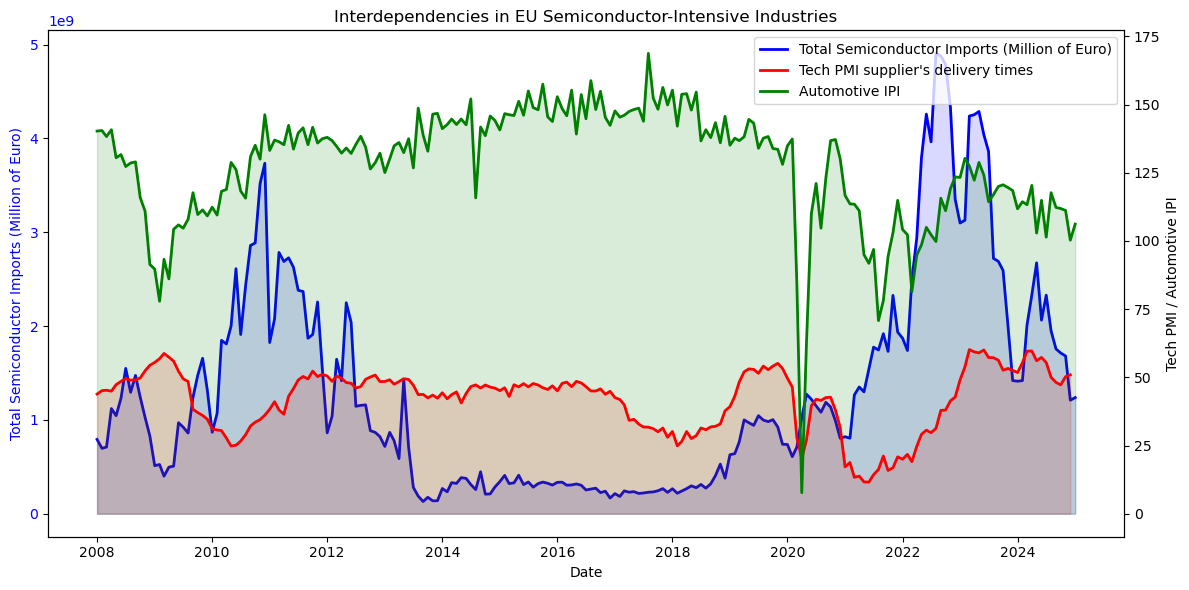

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel data from the "semi" sheet and parse dates
df = pd.read_excel('/Users/xinruyu/Desktop/Master paper/uplp/EU_Level_Combined_Dataset.xlsx', 
                   sheet_name='semi', 
                   parse_dates=['Date'])

# Convert relevant columns to numeric, forcing non-numeric items into NaN
for col in ['Diodes', 'Photosensitive', 'Other_Semi', 'PMI_Tech', 'ipiau']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Aggregate the semiconductor imports (measured in billions)
df['Total_Semi_Imports'] = df['Diodes'] + df['Photosensitive'] + df['Other_Semi']

# Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis: Total Semiconductor Imports
ax1.plot(df['Date'], df['Total_Semi_Imports'], label='Total Semiconductor Imports (Million of Euro)', 
         color='blue', linewidth=2)
# Add a filled area (shadow) under the Total Semiconductor Imports line
ax1.fill_between(df['Date'], df['Total_Semi_Imports'], color='blue', alpha=0.15)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Semiconductor Imports (Million of Euro)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis: Tech PMI and Automotive IPI
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['PMI_Tech'], label="Tech PMI supplier's delivery times", color='red', linewidth=2)
ax2.plot(df['Date'], df['ipiau'], label='Automotive IPI', color='green', linewidth=2)
# Add filled areas under the Tech PMI and Automotive IPI lines
ax2.fill_between(df['Date'], df['PMI_Tech'], color='red', alpha=0.15)
ax2.fill_between(df['Date'], df['ipiau'], color='green', alpha=0.15)
ax2.set_ylabel('Tech PMI / Automotive IPI', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Interdependencies in EU Semiconductor-Intensive Industries')
plt.tight_layout()
plt.show()


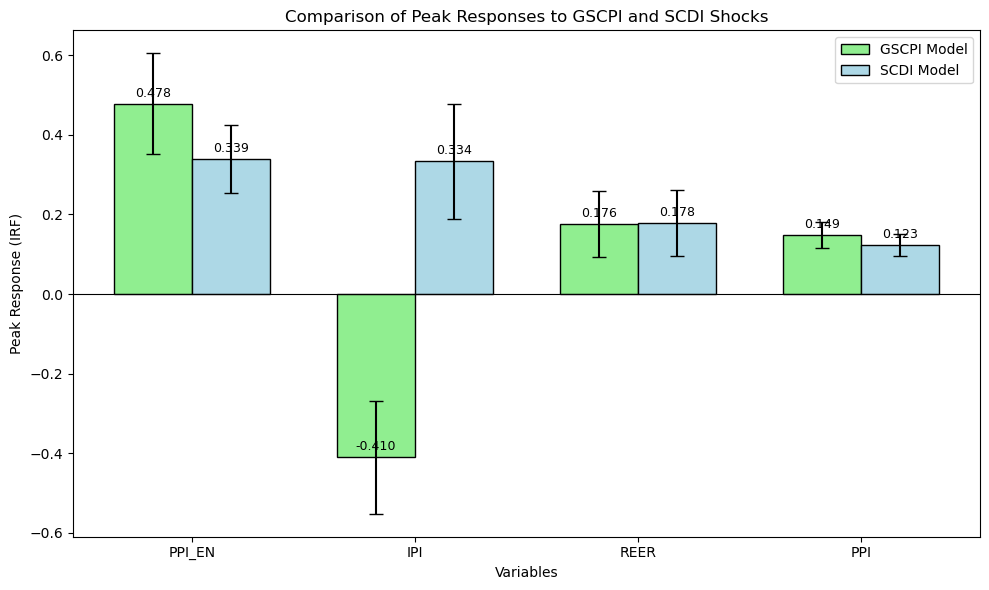

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for GSCPI Shock (GSCPI Model)
variables = ['PPI_EN', 'IPI', 'REER', 'PPI']
gscpi_peak = [0.478, -0.410, 0.176, 0.149]
gscpi_lower = [0.352, -0.552, 0.093, 0.116]
gscpi_upper = [0.605, -0.269, 0.259, 0.182]

# Data for SCDI Shock (SCDI Model)
scdi_peak = [0.339, 0.334, 0.178, 0.123]
scdi_lower = [0.254, 0.189, 0.095, 0.095]
scdi_upper = [0.424, 0.478, 0.262, 0.150]

# Calculate the asymmetric error bars for GSCPI
gscpi_err_lower = [peak - lower for peak, lower in zip(gscpi_peak, gscpi_lower)]
gscpi_err_upper = [upper - peak for peak, upper in zip(gscpi_peak, gscpi_upper)]

# Calculate the asymmetric error bars for SCDI
scdi_err_lower = [peak - lower for peak, lower in zip(scdi_peak, scdi_lower)]
scdi_err_upper = [upper - peak for peak, upper in zip(scdi_peak, scdi_upper)]

# Set positions of the bars on the x-axis
x = np.arange(len(variables))
bar_width = 0.35

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for GSCPI Model
bars1 = ax.bar(x - bar_width/2, gscpi_peak, bar_width,
               yerr=[gscpi_err_lower, gscpi_err_upper],
               capsize=5, label='GSCPI Model', color='lightgreen', edgecolor='black')

# Plot bars for SCDI Model
bars2 = ax.bar(x + bar_width/2, scdi_peak, bar_width,
               yerr=[scdi_err_lower, scdi_err_upper],
               capsize=5, label='SCDI Model', color='lightblue', edgecolor='black')

# Draw a horizontal line at y=0 for reference
ax.axhline(0, color='black', linewidth=0.8)

# Add labels and title
ax.set_xlabel('Variables')
ax.set_ylabel('Peak Response (IRF)')
ax.set_title('Comparison of Peak Responses to GSCPI and SCDI Shocks')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# Optional: add numerical labels above the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()
